# SKTIME

GitHub: https://github.com/alan-turing-institute/sktime

Documentation: https://www.sktime.org/en/stable/index.html


In [2]:
import pandas as pd
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc, plot_precision_recall_curve
from sklearn.metrics import average_precision_score, precision_recall_curve
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from sktime.datasets import load_basic_motions
from sktime.transformations.panel.compose import ColumnConcatenator
from sktime.datatypes._panel._convert import from_2d_array_to_nested
from sktime.classification.dictionary_based import BOSSEnsemble
from sktime.classification.compose import ColumnEnsembleClassifier
from sktime.classification.interval_based import TimeSeriesForestClassifier
from sktime.classification.interval_based import SupervisedTimeSeriesForest

import matplotlib.pyplot as plt
%matplotlib inline

## Load Dataset

In [3]:
target = 'activity'
ts_column = 'datetime'

# Train dataset
# Data source: https://www.kaggle.com/datasets/uciml/human-activity-recognition-with-smartphones
train = pd.read_csv("../data/human-activity-recognition/train.csv")

# Convert labels to binary
train[target] = pd.DataFrame(np.where(train['Activity']=='WALKING_DOWNSTAIRS', 1, 0))

# Drop unused columns
train.drop(['subject', 'Activity'], axis=1, inplace=True)

train.head(3)

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",activity
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,...,-0.298676,-0.710304,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627,0
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,...,-0.595051,-0.861499,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317,0
2,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,...,-0.390748,-0.760104,-0.118559,0.177899,0.100699,0.808529,-0.848933,0.180637,-0.049118,0


In [4]:
# Test dataset
test = pd.read_csv("../data/human-activity-recognition/test.csv")

# Convert labels to binary
test[target] = pd.DataFrame(np.where(test['Activity']=='WALKING_DOWNSTAIRS', 1, 0))

# Drop unused columns
test.drop(['subject', 'Activity'], axis=1, inplace=True)

test.head(3)

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",activity
0,0.257178,-0.023285,-0.014654,-0.938404,-0.920091,-0.667683,-0.952501,-0.925249,-0.674302,-0.894088,...,-0.330370,-0.705974,0.006462,0.162920,-0.825886,0.271151,-0.720009,0.276801,-0.057978,0
1,0.286027,-0.013163,-0.119083,-0.975415,-0.967458,-0.944958,-0.986799,-0.968401,-0.945823,-0.894088,...,-0.121845,-0.594944,-0.083495,0.017500,-0.434375,0.920593,-0.698091,0.281343,-0.083898,0
2,0.275485,-0.026050,-0.118152,-0.993819,-0.969926,-0.962748,-0.994403,-0.970735,-0.963483,-0.939260,...,-0.190422,-0.640736,-0.034956,0.202302,0.064103,0.145068,-0.702771,0.280083,-0.079346,0


In [ ]:
print('Train dataset shape:', train.shape)
print('Test dataset shape:', test.shape)

## Preprocess data

In [5]:
# Convert to nested dataframe
features = train.columns.difference([target, 'datetime'])

X_train = train[features]
X_train = from_2d_array_to_nested(X_train)
y_train = train[target]

X_test = test[features]
X_test = from_2d_array_to_nested(X_test)
y_test = test[target]

# X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42, shuffle=False, test_size=0.2)

# print('Dataset shape:', X_train.shape, y_train.shape, X_val.shape, y_val.shape)

print('Train dataset shape:', X_train.shape, y_train.shape)
print('Test dataset shape:', X_test.shape, y_test.shape)

Train dataset shape: (7352, 1) (7352,)
Test dataset shape: (2947, 1) (2947,)


In [ ]:
from sktime.registry import all_estimators

# all_estimators?
# A list of all available classifiers
all_estimators(estimator_types='classifier', return_names=False)

A list of all available classifiers:

```
[sktime.classification.kernel_based._arsenal.Arsenal,
 sktime.classification.dictionary_based._boss.BOSSEnsemble,
 sktime.classification.interval_based._cif.CanonicalIntervalForest,
 sktime.classification.feature_based._catch22_classifier.Catch22Classifier,
 sktime.classification.compose._pipeline.ClassifierPipeline,
 sktime.classification.compose._column_ensemble.ColumnEnsembleClassifier,
 sktime.classification.compose._ensemble.ComposableTimeSeriesForestClassifier,
 sktime.classification.dictionary_based._cboss.ContractableBOSS,
 sktime.classification.interval_based._drcif.DrCIF,
 sktime.classification.distance_based._elastic_ensemble.ElasticEnsemble,
 sktime.classification.feature_based._fresh_prince.FreshPRINCE,
 sktime.classification.hybrid._hivecote_v1.HIVECOTEV1,
 sktime.classification.hybrid._hivecote_v2.HIVECOTEV2,
 sktime.classification.dictionary_based._boss.IndividualBOSS,
 sktime.classification.dictionary_based._tde.IndividualTDE,
 sktime.classification.distance_based._time_series_neighbors.KNeighborsTimeSeriesClassifier,
 sktime.classification.dictionary_based._muse.MUSE,
 sktime.classification.feature_based._matrix_profile_classifier.MatrixProfileClassifier,
 sktime.classification.early_classification._probability_threshold.ProbabilityThresholdEarlyClassifier,
 sktime.classification.distance_based._proximity_forest.ProximityForest,
 sktime.classification.distance_based._proximity_forest.ProximityStump,
 sktime.classification.distance_based._proximity_forest.ProximityTree,
 sktime.classification.feature_based._random_interval_classifier.RandomIntervalClassifier,
 sktime.classification.interval_based._rise.RandomIntervalSpectralEnsemble,
 sktime.classification.kernel_based._rocket_classifier.RocketClassifier,
 sktime.classification.distance_based._shape_dtw.ShapeDTW,
 sktime.classification.shapelet_based._stc.ShapeletTransformClassifier,
 sktime.classification.feature_based._signature_classifier.SignatureClassifier,
 sktime.classification.feature_based._summary_classifier.SummaryClassifier,
 sktime.classification.interval_based._stsf.SupervisedTimeSeriesForest,
 sktime.classification.early_classification._teaser.TEASER,
 sktime.classification.feature_based._tsfresh_classifier.TSFreshClassifier,
 sktime.classification.dictionary_based._tde.TemporalDictionaryEnsemble,
 sktime.classification.interval_based._tsf.TimeSeriesForestClassifier,
 sktime.classification.dictionary_based._weasel.WEASEL]
```

## Train Model

sktime offers three main ways of solving multivariate time series classification problems:
* Concatenation 
* Column-wise ensembling 
* Bespoke estimator-specific methods

Reference: [Multivariate time series classification with sktime](https://www.sktime.org/en/v0.8.1/examples/03_classification_multivariate.html)

### Column ensembling

In [6]:
clf = ColumnEnsembleClassifier(
    estimators=[
        # ("TSF0", TimeSeriesForestClassifier(random_state=42), 0),
        # ("BOSSEnsemble3", BOSSEnsemble(max_ensemble_size=5,random_state=42), 0),
        ('STSF0', SupervisedTimeSeriesForest(n_estimators=5, random_state=42), 0)
    ]
)

clf.fit(X_train, y_train)

print('Training accuracy score', clf.score(X_train, y_train))

Training accuracy score 0.9995919477693145


Exception while using BOSSEnsemble3:

```
TypeError: loop of ufunc does not support argument 0 of type float which has no callable sqrt method
```

In [7]:
# Evaluate the model

# Predict y testues
y_pred = clf.predict(X_test)

# print accuracy
print("Accuracy: ", accuracy_score(y_test, y_pred))

# print precision, recall, F1-score per each class/tag
print('Classification report:')
print(classification_report(y_test, y_pred))

# print confusion matrix, check documentation for sorting rows/columns
print('Confusion matrix')
print(confusion_matrix(y_test, y_pred))

Accuracy:  0.9701391245334238
Classification report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      2527
           1       0.95      0.83      0.89       420

    accuracy                           0.97      2947
   macro avg       0.96      0.91      0.94      2947
weighted avg       0.97      0.97      0.97      2947

Confusion matrix
[[2510   17]
 [  71  349]]


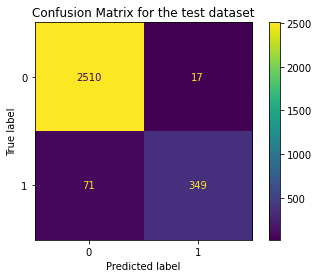

In [12]:
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()
plt.title('Confusion Matrix for the test dataset')
plt.show()

### Time series concatenation

In [13]:
steps = [
    ("concatenate", ColumnConcatenator()),
    ("classify", SupervisedTimeSeriesForest(n_estimators=5, random_state=42)),
]

clf = Pipeline(steps)
clf.fit(X_train, y_train)

Pipeline(steps=[('concatenate', ColumnConcatenator()),
                ('classify',
                 SupervisedTimeSeriesForest(n_estimators=5, random_state=42))])

In [16]:
# Evaluate the model

# Predict y testues
y_pred = clf.predict(X_test)

# print accuracy
print("Test Accuracy: ", accuracy_score(y_test, y_pred))

# print precision, recall, F1-score per each class/tag
print('Classification report:')
print(classification_report(y_test, y_pred))

# print confusion matrix, check documentation for sorting rows/columns
print('Confusion matrix')
print(confusion_matrix(y_test, y_pred))

Test Accuracy:  0.9701391245334238
Classification report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      2527
           1       0.95      0.83      0.89       420

    accuracy                           0.97      2947
   macro avg       0.96      0.91      0.94      2947
weighted avg       0.97      0.97      0.97      2947

Confusion matrix
[[2510   17]
 [  71  349]]


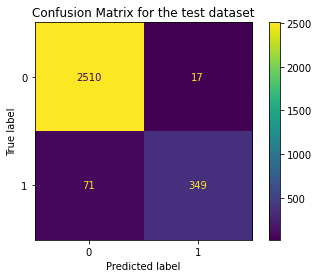

In [15]:
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()
plt.title('Confusion Matrix for the test dataset')
plt.show()

In [17]:
# Get the predicited probability of testing data
y_score = clf.predict_proba(X_test)[:, 1]

In [18]:
# Average precision score
average_precision = average_precision_score(y_test, y_score)
print('AVG Precision:', average_precision)

AVG Precision: 0.9277776334012855


In [19]:
# Data to plot precision - recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_score)
# Use AUC function to calculate the area under the curve of precision recall curve
auc_precision_recall = auc(recall, precision)
print('AUC:', auc_precision_recall)

AUC: 0.9499754060286587


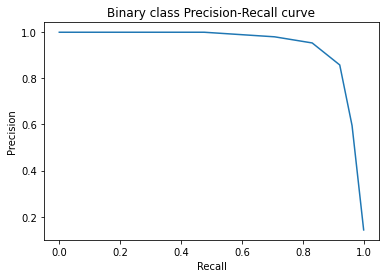

In [20]:
plt.plot(recall, precision)
plt.title('Binary class Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

====================================

In [23]:
trainx = pd.read_csv("../data/human-activity-recognition/train.csv")
trainx.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,Activity
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,...,-0.710304,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627,1,STANDING
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,...,-0.861499,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317,1,STANDING
2,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,...,-0.760104,-0.118559,0.177899,0.100699,0.808529,-0.848933,0.180637,-0.049118,1,STANDING
3,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,-0.989302,-0.938692,...,-0.482845,-0.036788,-0.012892,0.640011,-0.485366,-0.848649,0.181935,-0.047663,1,STANDING
4,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,-0.990441,-0.942469,...,-0.699205,0.123320,0.122542,0.693578,-0.615971,-0.847865,0.185151,-0.043892,1,STANDING


In [24]:
trainx.shape

(7352, 563)

In [26]:
trainx[trainx['subject'] == 1].shape

(347, 563)

In [32]:
trainx[trainx['subject'] == 1]['Activity'].value_counts()

WALKING               95
STANDING              53
WALKING_UPSTAIRS      53
LAYING                50
WALKING_DOWNSTAIRS    49
SITTING               47
Name: Activity, dtype: int64

In [31]:
trainx[trainx['subject'] == 1]['Activity'].values #.value_counts()

array(['STANDING', 'STANDING', 'STANDING', 'STANDING', 'STANDING',
       'STANDING', 'STANDING', 'STANDING', 'STANDING', 'STANDING',
       'STANDING', 'STANDING', 'STANDING', 'STANDING', 'STANDING',
       'STANDING', 'STANDING', 'STANDING', 'STANDING', 'STANDING',
       'STANDING', 'STANDING', 'STANDING', 'STANDING', 'STANDING',
       'STANDING', 'STANDING', 'SITTING', 'SITTING', 'SITTING', 'SITTING',
       'SITTING', 'SITTING', 'SITTING', 'SITTING', 'SITTING', 'SITTING',
       'SITTING', 'SITTING', 'SITTING', 'SITTING', 'SITTING', 'SITTING',
       'SITTING', 'SITTING', 'SITTING', 'SITTING', 'SITTING', 'SITTING',
       'SITTING', 'SITTING', 'LAYING', 'LAYING', 'LAYING', 'LAYING',
       'LAYING', 'LAYING', 'LAYING', 'LAYING', 'LAYING', 'LAYING',
       'LAYING', 'LAYING', 'LAYING', 'LAYING', 'LAYING', 'LAYING',
       'LAYING', 'LAYING', 'LAYING', 'LAYING', 'LAYING', 'LAYING',
       'LAYING', 'LAYING', 'LAYING', 'LAYING', 'LAYING', 'WALKING',
       'WALKING', 'WALKING', 'WAL

In [49]:
def rolling_agg_list(src_frame, cols, window):
    frame = src_frame[cols]
    d = {v: list for v in cols}
    values = [frame.iloc[i:i + window].agg(d)
              for i in range(len(frame) - window + 1)]
    return pd.DataFrame(values, columns=cols)

df = pd.DataFrame({
    'ID': np.arange(1, 11),
    'X': np.random.randint(118, 122, size=10),
    'Y': np.random.random(size=10) * 2 - 1,
    'Z': np.random.random(size=10) * 2 - 1
})

display(df.head())
display(f'df.shape=={df.shape}')

new_df = rolling_agg_list(df, ['X', 'Y', 'Z'], 3)

display(new_df)
display(f'new_df.shape=={new_df.shape}')

,ID,X,Y,Z
0,1,120,0.105414,-0.861162
1,2,118,0.917096,0.862859
2,3,119,0.852389,-0.062282
3,4,119,0.325224,-0.526002
4,5,119,0.131289,-0.801114


'df.shape==(10, 4)'

,X,Y,Z
0,"[120, 118, 119]","[0.1054136059669537, 0.917096212912355, 0.8523...","[-0.8611621913032916, 0.862858929919786, -0.06..."
1,"[118, 119, 119]","[0.917096212912355, 0.8523885692471003, 0.3252...","[0.862858929919786, -0.06228233909002956, -0.5..."
2,"[119, 119, 119]","[0.8523885692471003, 0.32522420910395256, 0.13...","[-0.06228233909002956, -0.5260023018061704, -0..."
3,"[119, 119, 118]","[0.32522420910395256, 0.1312888254020823, -0.2...","[-0.5260023018061704, -0.8011138220480165, -0...."
4,"[119, 118, 121]","[0.1312888254020823, -0.2318320739076012, -0.5...","[-0.8011138220480165, -0.38261461586121204, -0..."
5,"[118, 121, 118]","[-0.2318320739076012, -0.5063388434141689, -0....","[-0.38261461586121204, -0.8970912695450088, 0...."
6,"[121, 118, 119]","[-0.5063388434141689, -0.6759681072996198, 0.9...","[-0.8970912695450088, 0.5114296490037451, 0.97..."
7,"[118, 119, 118]","[-0.6759681072996198, 0.9026202074294911, 0.90...","[0.5114296490037451, 0.9742543491433295, -0.76..."


'new_df.shape==(8, 3)'

### FordA Dataset

In [50]:
def readucr(filename):
    data = np.loadtxt(filename, delimiter="\t")
    y = data[:, 0]
    x = data[:, 1:]
    return x, y.astype(int)


root_url = "https://raw.githubusercontent.com/hfawaz/cd-diagram/master/FordA/"

x_train, y_train = readucr(root_url + "FordA_TRAIN.tsv")
x_test, y_test = readucr(root_url + "FordA_TEST.tsv")

In [51]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3601, 500), (3601,), (1320, 500), (1320,))

In [52]:
x_train[0:5]

array([[-0.79717168, -0.66439208, -0.37301463, ..., -0.66439208,
        -1.0737958 , -1.5643427 ],
       [ 0.80485472,  0.63462859,  0.37347448, ..., -0.71488505,
        -0.56044294, -0.31908642],
       [ 0.7279851 ,  0.11128392, -0.49912439, ...,  0.39446303,
         0.33940042,  0.25539062],
       [-0.23443909, -0.50215697, -0.73248781, ..., -0.47879007,
        -0.18870673,  0.11973631],
       [-0.17132785, -0.06228531,  0.235829  , ...,  0.43751994,
        -0.02658494, -0.60221303]])

In [53]:
np.unique(np.concatenate((y_train, y_test), axis=0))

array([-1,  1])

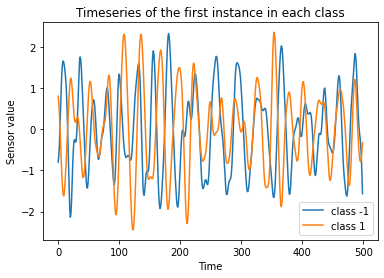

In [58]:
classes = np.unique(np.concatenate((y_train, y_test), axis=0))

plt.figure()
for c in classes:
    c_x_train = x_train[y_train == c]
    plt.plot(c_x_train[0], label="class " + str(c))
plt.legend(loc="best")
plt.title('Timeseries of the first instance in each class')
plt.xlabel('Time')
plt.ylabel('Sensor value')
plt.show()
plt.close()
